In [1]:
import os
import numpy  as np 
import warnings
warnings.filterwarnings("ignore")

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Function to Plit Random Images

In [2]:
def plot_random_images(dataset_dir, category, num_images):
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    images_files = os.listdir(category_dir)
    random_images = random.sample(images_files, num_images)
    plt.figure(figsize=(12, 8))
    for i, image_name in enumerate(random_images):
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        

        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")
        plt.axis("off")
    plt.show()

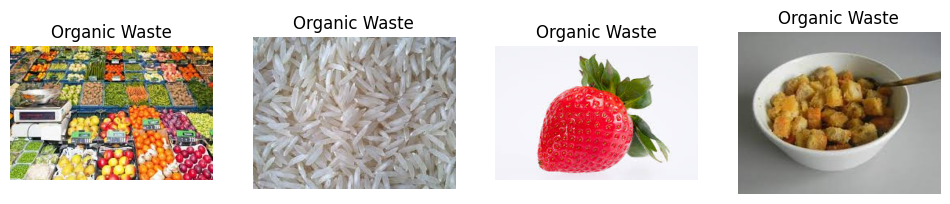

In [3]:
dataset_dir = './dataset/Waste Classification data/DATASET/DATASET'
plot_random_images(dataset_dir, 'O', 4)

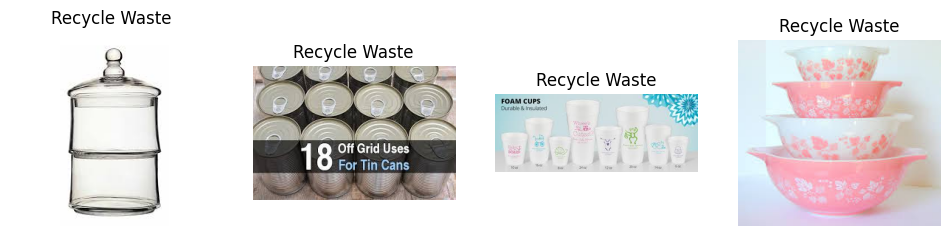

In [4]:
plot_random_images(dataset_dir, 'R', 4)

In [5]:
train_directory = "./dataset/Waste Classification data/DATASET/DATASET/TRAIN"
test_directory = "./dataset/Waste Classification data/DATASET/DATASET/TEST"

In [6]:
train_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1.0/255.0,
    validation_split = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)
validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rescale=1.0/255.0,
    horizontal_flip=True
)
test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input   ,
    rescale=1.0/255.0   
)

In [7]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size = (150, 150),
    class_mode = 'binary',
    batch_size = 32,
    classes=['O', 'R'],
    subset='training', shuffle=True, seed=10
)

Found 18052 images belonging to 2 classes.


In [8]:
val_generator = validation_data_generator.flow_from_directory(
    train_directory,
    target_size = (150, 150),
    class_mode = 'binary',
    batch_size = 32,
    classes=['O', 'R'],
    subset='validation', shuffle=True, seed=10 
)

Found 4512 images belonging to 2 classes.


In [9]:
test_generator = test_data_generator.flow_from_directory(
    test_directory,
    classes=['O', 'R'],
    class_mode = 'binary',
    seed=10,
    batch_size = 32,
    shuffle=True, target_size = (150, 150)
)

Found 2513 images belonging to 2 classes.


In [10]:
core = VGG16(
    include_top=False, weights = 'imagenet', input_shape=(150, 150, 3)
)
core.trainable = True

In [11]:
model = Sequential()
model.add(core)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
checkpoint_path = 'O_R_tlearn_image_augm_cnn_vgg16.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
history = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/15
  8/565 ━━━━━━━━━━━━━━━━━━━━ 27:55:41 181s/step - accuracy: 0.5252 - loss: 0.8414

In [1]:
import matplotlib.pyplot as plt

In [ ]:
def plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(12, 5)):
    num_metrics = len(metrics)
    plt.figure(figsize=figsize)
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, i);
        plt.plot(history.epoch, history.history[metric], label='Training' + metric)
        plt.plot(history.epoch, history.history['val_' + metric], label='validation' + metric)
        plt.title('Training and Validation ' + metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(16, 6))

In [ ]:
evaluation = model.evaluate(test_generator)
print(f'test Loss: {evaluation[0]:.4f}')
print(f'test Accuracy: {evaluation[1] * 100:.2f}%') 